# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [2]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [3]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
adni2 = img_adni2.loc[img_adni2['VISCODE2'] == "sc"]
adni3 = img_adni3.loc[img_adni3['VISCODE2'] == "sc"]
adni1 = img_adni1.loc[img_adni1['VISCODE'] == 'bl']

In [5]:
#CVs = []
SVs = []
#SAs = []
#TSs = []
TAs = []
#HSs = []

for col in imgdx2.columns:
    
    #if col.endswith('CV'):
        #CVs.append(col)
    if col.endswith('SV'):
        SVs.append(col)
    """
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('HS'):
        HSs.append(col)
    """
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE")
TAs.append("VISCODE2")


In [6]:
dxbl_subset = dx.loc[:,["VISCODE", "VISCODE2", "RID", "DXCHANGE","DXCURREN","DIAGNOSIS", "PTID"]].copy()
imgdx2 = pd.merge(adni2.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx3 = pd.merge(adni3.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx1 = pd.merge(adni1.loc[:,TAs2].copy(), dxbl_subset, on=["RID", "VISCODE"])

In [7]:
imgdx2["PTID"].append(imgdx3['PTID'].append(imgdx1['PTID'])).nunique()

1598

In [8]:

imgdx2.loc[(imgdx2["DXCHANGE"] == 1) | (imgdx2["DXCHANGE"] == 4) |(imgdx2["DXCHANGE"] == 6), 'DXCHANGE'] = 1
imgdx2.loc[(imgdx2["DXCHANGE"] == 2) | (imgdx2["DXCHANGE"] == 5) |(imgdx2["DXCHANGE"] == 7), 'DXCHANGE'] = 2
imgdx2.loc[(imgdx2["DXCHANGE"] == 3) | (imgdx2["DXCHANGE"] == 8) |(imgdx2["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [10]:
imgdx1

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST97TA,ST98TA,ST99TA,RID,VISCODE,VISCODE2,DXCHANGE,DXCURREN,DIAGNOSIS,PTID
0,2.187,2.617,2.357,2.301,2.346,1.492,1.711,2.335,2.228,2.147,...,1.889,2.201,2.573,15,bl,bl,NaN,1.0,NaN,100_S_0015
1,2.423,2.960,2.378,2.499,2.363,1.612,2.033,2.574,2.604,2.325,...,1.901,2.387,2.788,86,bl,bl,NaN,1.0,NaN,136_S_0086
2,2.287,2.536,2.303,2.881,2.305,1.463,1.909,2.858,2.382,2.248,...,1.988,2.414,2.740,184,bl,bl,NaN,1.0,NaN,136_S_0184
3,2.004,2.372,2.294,2.168,2.018,1.713,1.672,1.991,2.108,1.898,...,1.809,2.168,2.139,187,bl,bl,NaN,2.0,NaN,032_S_0187
4,1.979,1.897,2.244,2.272,2.085,1.327,1.784,2.132,2.196,1.946,...,1.764,2.063,2.379,190,bl,bl,NaN,3.0,NaN,100_S_0190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2.308,2.118,2.485,2.508,2.433,1.776,1.954,2.403,2.412,2.260,...,2.129,2.345,2.736,1326,bl,bl,NaN,2.0,NaN,016_S_1326
108,2.232,2.753,2.544,2.412,2.324,1.789,1.891,2.445,2.306,2.172,...,2.067,2.597,2.570,1331,bl,bl,NaN,2.0,NaN,051_S_1331
109,2.058,2.255,2.191,2.166,2.209,1.499,1.779,2.412,1.991,2.218,...,1.814,2.419,2.642,1337,bl,bl,NaN,3.0,NaN,130_S_1337
110,2.347,2.445,2.550,2.475,2.165,1.961,1.833,2.221,2.201,2.169,...,2.040,2.335,2.768,1338,bl,bl,NaN,2.0,NaN,051_S_1338


In [12]:
imgdx1.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx2.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx3.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)

img = imgdx1.append(imgdx2.append(imgdx3))

In [13]:
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCHANGE'])
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCURREN'])
img.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [14]:
img.columns

Index(['ST102TA', 'ST103TA', 'ST104TA', 'ST105TA', 'ST106TA', 'ST107TA',
       'ST108TA', 'ST109TA', 'ST110TA', 'ST111TA', 'ST113TA', 'ST114TA',
       'ST115TA', 'ST116TA', 'ST117TA', 'ST118TA', 'ST119TA', 'ST121TA',
       'ST129TA', 'ST130TA', 'ST13TA', 'ST14TA', 'ST15TA', 'ST23TA', 'ST24TA',
       'ST25TA', 'ST26TA', 'ST31TA', 'ST32TA', 'ST34TA', 'ST35TA', 'ST36TA',
       'ST38TA', 'ST39TA', 'ST40TA', 'ST43TA', 'ST44TA', 'ST45TA', 'ST46TA',
       'ST47TA', 'ST48TA', 'ST49TA', 'ST50TA', 'ST51TA', 'ST52TA', 'ST54TA',
       'ST55TA', 'ST56TA', 'ST57TA', 'ST58TA', 'ST59TA', 'ST60TA', 'ST62TA',
       'ST72TA', 'ST73TA', 'ST74TA', 'ST82TA', 'ST83TA', 'ST84TA', 'ST85TA',
       'ST90TA', 'ST91TA', 'ST93TA', 'ST94TA', 'ST95TA', 'ST97TA', 'ST98TA',
       'ST99TA', 'DIAGNOSIS', 'VISCODE'],
      dtype='object')

In [17]:

data = img
data_sane = data[data['DIAGNOSIS'] !=3].mean(axis=0)
stddev_sane = data[data['DIAGNOSIS'] !=3].std(axis=0)
data_alz = data[data['DIAGNOSIS'] == 3].mean(axis=0)

In [19]:
data_sane - data_alz

ST102TA      0.054250
ST103TA      0.242794
ST104TA      0.086035
ST105TA      0.094299
ST106TA      0.056793
               ...   
ST95TA       0.093075
ST97TA       0.072315
ST98TA       0.059556
ST99TA       0.203466
DIAGNOSIS   -1.522207
Length: 69, dtype: float64

In [83]:
len(img[(img['VISCODE'] == 'bl') | (img['VISCODE2'] == 'bl')])

114

In [115]:
diff = data_sane - data_alz


In [116]:
diff

ST102TA     -0.910481
ST103TA     -0.808986
ST104TA     -0.873232
ST105TA     -0.855601
ST106TA     -0.883295
               ...   
ST95TA      -0.856424
ST97TA      -0.943552
ST98TA      -0.875327
ST99TA      -0.832490
DIAGNOSIS   -1.376717
Length: 69, dtype: float64

In [28]:
TAs1 = TAs
TAs1[-1] = "DXCURREN"
data1 = img_dx1.loc[:, TAs1]
data1_sane = data1[data1['DXCURREN'] == 1].mean(axis=0)
data1_alz = data1[data1['DXCURREN'] == 3].mean(axis=0)
data1_sane - data1_alz

ST102TA     0.001200
ST103TA     0.366961
ST104TA     0.027504
ST105TA     0.070647
ST106TA     0.071525
              ...   
ST95TA      0.067430
ST97TA      0.026119
ST98TA      0.082605
ST99TA      0.182645
DXCURREN   -2.000000
Length: 69, dtype: float64

,RID,VISCODE,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,OVERALLQC,TEMPQC,...,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,PTID,VISCODE2,DIAGNOSIS
4,15,bl,2005-10-31 00:00:00,2013-08-07,8833.0,33046,2013-08-07,partial,Pass,Pass,...,217061.0000,216157.0000,433218.0000,167556.0,550001.0000,928508.000,2016-02-02 09:34:17.0,100_S_0015,NaN,1.0
32,187,bl,2006-03-14 00:00:00,2013-08-06,12179.0,36440,2013-08-06,partial,Pass,Pass,...,217531.0000,226045.0000,443576.0000,152176.0,505159.0000,921752.000,2016-02-02 09:34:18.0,032_S_0187,NaN,2.0
30,184,bl,2006-03-27 00:00:00,2013-08-09,12474.0,119712,2013-08-09,partial,Pass,Pass,...,194113.0000,192462.0000,386574.0000,167712.0,519633.0000,822186.000,2016-02-02 09:34:18.0,136_S_0184,NaN,1.0
43,195,bl,2006-04-04 00:00:00,2013-10-25,12748.0,119721,2013-10-25,partial,Fail,Fail,...,185561.0000,193979.0000,379540.0000,141439.0,519219.0000,877800.000,2016-02-02 09:34:18.0,136_S_0195,NaN,2.0
72,324,bl,2006-04-21 00:00:00,2013-04-18,13664.0,32777,2013-04-18,partial,Pass,Pass,...,199828.0000,200018.0000,399846.0000,143383.0,486316.0000,830924.000,2016-02-02 09:34:18.0,005_S_0324,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1138,bl,2007-04-19 00:00:00,2013-12-23,30118.0,90875,2013-12-23,partial,Pass,Pass,...,214409.0000,223677.0000,438086.0000,160253.0,518337.0000,916212.000,2016-02-02 09:34:20.0,016_S_1138,NaN,2.0
476,1338,bl,2007-04-26 00:00:00,2014-01-06,30842.0,82518,2014-01-06,partial,Partial,Pass,...,207341.0000,203875.0000,411217.0000,161985.0,584631.0000,978615.000,2016-02-02 09:34:21.0,051_S_1338,NaN,2.0
468,1331,bl,2007-04-26 00:00:00,2013-08-06,30826.0,82509,2013-08-06,partial,Pass,Pass,...,178370.0000,182431.0000,360801.0000,153736.0,512916.0000,820364.000,2016-02-02 09:34:20.0,051_S_1331,NaN,2.0
1763,6861,bl,2020-03-10 00:00:00,2021-04-12,933063.0,1301722,2021-04-12,complete,Pass,Pass,...,278200.2762,277386.6656,555586.9418,61768.0,686825.0018,1151061.944,2022-08-26 14:42:03.0,053_S_6861,bl,2.0


In [39]:
TAs2 = TAs
TAs2[-1] = "DXCHANGE"
imgdx2go = img_dx2go[img_dx2go['VISCODE2'] == 'bl'].copy()
print(len(img_dx2go))
data2 = imgdx2go.loc[:, TAs2]
data2_sane = data2[data2['DXCHANGE'] == 1].mean(axis=0)
data2_alz = data2[data2['DXCHANGE'] == 3].mean(axis=0)
data2_sane - data2_alz

2709


ST102TA    NaN
ST103TA    NaN
ST104TA    NaN
ST105TA    NaN
ST106TA    NaN
            ..
ST95TA     NaN
ST97TA     NaN
ST98TA     NaN
ST99TA     NaN
DXCHANGE   NaN
Length: 69, dtype: float64

In [32]:
TAs3 = TAs
TAs3[-1] = "DIAGNOSIS"
data3 = img_dx3.loc[:, TAs3]
print(len)
data3_sane = data3[data3['DIAGNOSIS'] == 1].mean(axis=0)
data3_alz = data3[data3['DIAGNOSIS'] == 3].mean(axis=0)
data3_sane - data3_alz

ST102TA      0.084173
ST103TA      0.297627
ST104TA      0.132577
ST105TA      0.063427
ST106TA      0.085983
               ...   
ST95TA       0.096990
ST97TA       0.043673
ST98TA       0.068916
ST99TA       0.212548
DIAGNOSIS   -2.000000
Length: 69, dtype: float64

In [33]:
img

,RID,VISCODE,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,OVERALLQC,TEMPQC,...,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,PTID,VISCODE2,DIAGNOSIS
4,15,bl,2005-10-31 00:00:00,2013-08-07,8833.0,33046,2013-08-07,partial,Pass,Pass,...,217061.0000,216157.0000,433218.0000,167556.0,550001.0000,9.285080e+05,2016-02-02 09:34:17.0,100_S_0015,NaN,1.0
32,187,bl,2006-03-14 00:00:00,2013-08-06,12179.0,36440,2013-08-06,partial,Pass,Pass,...,217531.0000,226045.0000,443576.0000,152176.0,505159.0000,9.217520e+05,2016-02-02 09:34:18.0,032_S_0187,NaN,2.0
30,184,bl,2006-03-27 00:00:00,2013-08-09,12474.0,119712,2013-08-09,partial,Pass,Pass,...,194113.0000,192462.0000,386574.0000,167712.0,519633.0000,8.221860e+05,2016-02-02 09:34:18.0,136_S_0184,NaN,1.0
43,195,bl,2006-04-04 00:00:00,2013-10-25,12748.0,119721,2013-10-25,partial,Fail,Fail,...,185561.0000,193979.0000,379540.0000,141439.0,519219.0000,8.778000e+05,2016-02-02 09:34:18.0,136_S_0195,NaN,2.0
72,324,bl,2006-04-21 00:00:00,2013-04-18,13664.0,32777,2013-04-18,partial,Pass,Pass,...,199828.0000,200018.0000,399846.0000,143383.0,486316.0000,8.309240e+05,2016-02-02 09:34:18.0,005_S_0324,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,7029,sc,2022-01-10 00:00:00,2022-03-10,1095392.0,1532649,2022-03-10,complete,Pass,Pass,...,222870.8114,219711.0829,442581.8942,49614.0,586429.8798,9.421738e+05,2022-08-26 14:42:03.0,067_S_7029,sc,2.0
1781,6894,y1,2022-01-11 00:00:00,2022-06-28,1095705.0,1533065,2022-06-28,partial,NaN,NaN,...,249270.9399,243185.7534,492456.6933,53146.0,619211.0363,1.068116e+06,2022-08-26 14:42:03.0,036_S_6894,m12,2.0
1857,7044,sc,2022-02-21 00:00:00,2022-06-28,1106750.0,1546901,2022-06-28,partial,NaN,NaN,...,187163.5753,182168.4643,369332.0396,42613.0,524582.6837,8.829197e+05,2022-08-26 14:42:03.0,036_S_7044,sc,2.0
1858,7048,sc,2022-03-18 00:00:00,2022-05-19,1115524.0,1558064,2022-05-19,partial,NaN,NaN,...,197638.1075,197956.7592,395594.8667,55446.0,556212.4274,8.836193e+05,2022-08-26 14:42:03.0,011_S_7048,sc,1.0


## Create the classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

### Feature selection

<AxesSubplot:xlabel='DIAGNOSIS', ylabel='Count'>

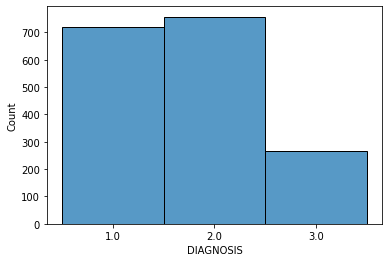

In [127]:
sns.histplot(img['DIAGNOSIS'].astype(str))

In [ ]:
Y = img['Diagnosis']


### Model training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(basic_diagnosis_features, Y, test_size=0.4, train_size=0.6)

### Cross-validation

In [128]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

### Evaluation

## Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.